### 1. Import required modules

In [8]:
import matplotlib.lines as mlines
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import json
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 22})

### 2. Helper methods

In [9]:
def load_results(infile,quartile,scores,metric,granularity):
    next(infile)
    for line in infile:
        queryid,numreplaced,match,score=line.strip().split()
        numreplaced=int(numreplaced)
        if metric not in scores:
            scores[metric]=dict()
        if quartile not in scores[metric]:
            scores[metric][quartile]=dict()
        if granularity not in scores[metric][quartile]:
            scores[metric][quartile][granularity]=dict()
        if numreplaced not in scores[metric][quartile][granularity]:
            scores[metric][quartile][granularity][numreplaced]=[]
        scores[metric][quartile][granularity][numreplaced].append(float(score))

    infile.close()
    return scores

def error(scorelist):
    return 2*(np.std(scorelist)/math.sqrt(len(scorelist)))

### 3. Plot Annotation IC vs Profile IC

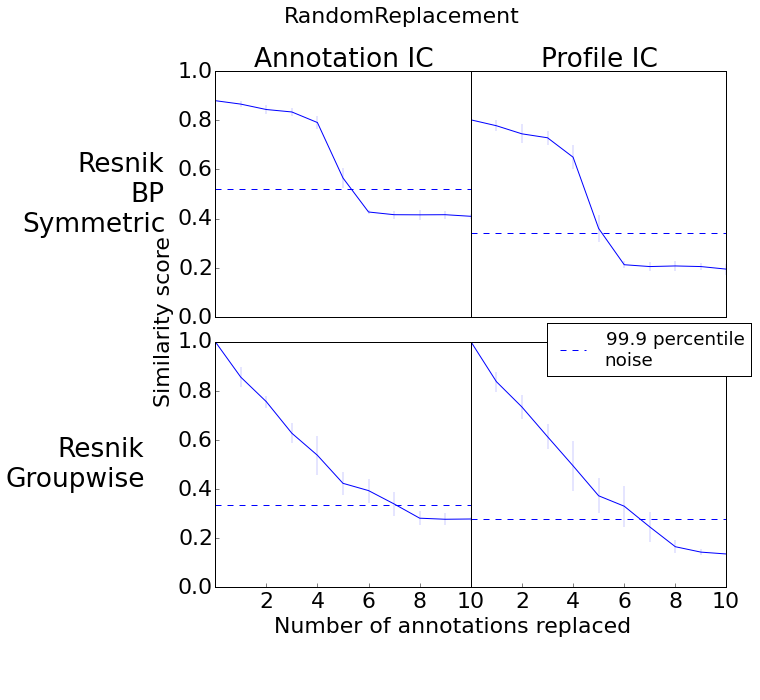

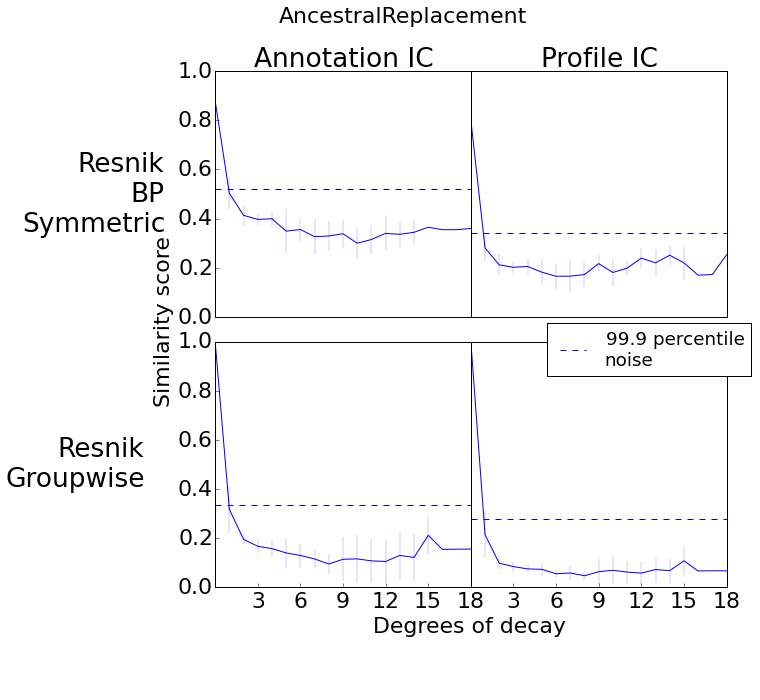

In [19]:
quartile=50
granularity='E'
titledict={'BPSym__Jaccard':'Jaccard',  'BPAsym__Jaccard':'Jaccard','BPSym_AIC_Resnik':'Resnik','BPSym_PIC_Resnik':'Resnik', 'BPAsym_AIC_Resnik':'Resnik'  , 'BPSym_AIC_Lin':'Lin',  'BPAsym_AIC_Lin':'Lin',  'BPSym_AIC_Jiang':'Jiang', 'BPAsym_AIC_Jiang':'Jiang', '_AIC_simGIC':'simGIC','_PIC_simGIC':'simGIC','BPAsym_AIC_HRSS':'HRSS',  'BPSym_AIC_HRSS':'HRSS','Groupwise_Jaccard':'Groupwise Jaccard','AP__Jaccard':'Jaccard','AP_AIC_HRSS':'HRSS','AP_AIC_Lin':'Lin','AP_AIC_Resnik':'Resnik','AP_AIC_Jiang':'Jiang'}
colors={10:'blue',20:'green',40:'red'}
metrics=['BPSym_AIC_Resnik','BPSym_PIC_Resnik','_AIC_simGIC','_PIC_simGIC']
lines=[]
legend=[]
for decaytype in ["RandomReplacement","AncestralReplacement"]:
    scores=dict()
    f, axarr = plt.subplots(2, 2)
    i=j=0
    imax=1
    jmax=1
    figname="../../results/"+decaytype+"Level2-AICvsPIC.png"
    for metric in metrics:
        if "AP" in metric:
            direction="AP"
            pairing ="AP"
        elif "BPSym" in metric:
            direction="BP Symmetric"
            pairing ="BP"
        elif "BPAsym" in metric:
            direction="BP Asymmetric"
            pairing ="BP"
        elif "simGIC" in metric or "Groupwise_Jaccard" in metric:
            direction="Groupwise"
            pairing =""
        if "Groupwise_Jaccard" in metric:
            metricname=metric
        else:
            metricname=titledict[metric]
        for profilesize in [10]:
            if "simGIC" in metricname or "Groupwise_Jaccard" in metricname:
                resfile="../../results/FullDistribution/"+decaytype+"/"+metricname+"/Decay/E_Decay_ProfileSize"+str(profilesize)+"_"+ metric+"_Results.tsv"
            else:
                resfile="../../results/FullDistribution/"+decaytype+"/"+metricname+"/"+pairing+"/Decay/E_Decay_Quartile50_ProfileSize"+str(profilesize)+"_"+ metric+"_Results.tsv"
            if os.path.isfile(resfile):
                infile=open(resfile)
                scores=load_results(infile,quartile,scores,metric,granularity)
                infile.close()
                signallist=[]
                errorlist=[]
                numreplacedlist=sorted(scores[metric][quartile][granularity].keys())
                for numreplaced in numreplacedlist :
                    signallist.append(np.mean(scores[metric][quartile][granularity][numreplaced]))
                    errorlist.append(error(scores[metric][quartile][granularity][numreplaced]))
                line=axarr[i][j].errorbar(numreplacedlist,signallist,yerr=errorlist,color=colors[profilesize],capsize=0, elinewidth=0.2)
                axarr[i][j].set_yticks([0.0, 0.2, 0.4,0.6,0.8,1])                    
                if decaytype=="RandomReplacement":
                    axarr[i][j].set_xticks([2,4,6,8,10])
                else:
                    axarr[i][j].set_xticks([3,6,9,12,15,18])
                axarr[i][j].get_xaxis().tick_bottom()
                axarr[i][j].yaxis.set_ticks_position('left')
                if i!=1:
                    axarr[i][j].get_xaxis().set_visible(False)
                    #axarr[i][j].spines['bottom'].set_visible(False)
                if j==0:
                    if decaytype=="RandomReplacement":
                        axarr[i][j].set_xlabel('                               Number of annotations replaced')
                    else:
                        axarr[i][j].set_xlabel('                                    Degrees of decay')
                if j!=0:
                    axarr[i][j].get_yaxis().set_visible(False)
                elif i==1:
                    axarr[i][j].set_ylabel('                                         Similarity score')
                axarr[i][j].set_ylim(0,1)
                axarr[i][j].set_xlim(0,max(numreplacedlist))
            
            if "simGIC" in metric or "Groupwise_Jaccard" in metric:
                noisefile="../../results/FullDistribution/RandomReplacement/"+metricname+"/Noise/"+granularity+"_NoiseDist_Decay_ProfileSize"+str(profilesize)+"_"+metric+"_Results.tsv"
            else:
                noisefile="../../results/FullDistribution/RandomReplacement/"+metricname+"/Noise/Distributions/"+granularity+"_NoiseDist50_Decay_Quartile"+str(quartile)+"_ProfileSize"+str(profilesize)+"_"+metric+"_Results.tsv"
            if os.path.isfile(noisefile):
                noisedist= json.load(open(noisefile))

                line=axarr[i][j].axhline(y=np.percentile(noisedist,99.9),linestyle='--',color='blue',label='_nolegend_')
                if "99.9 percentile \nnoise" not in legend:
                    lines.append(line)
                    legend.append("99.9 percentile \nnoise")
        if j==jmax:
            j=0
            i+=1
        else:
            j+=1 
    pad = 5 
    for ax, col in zip(axarr[0], ['Annotation IC','Profile IC']):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    for ax, row in zip(axarr[:,0], ['Resnik\nBP\nSymmetric','Resnik\nGroupwise']):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center') 

    leg=plt.figlegend(lines, legend,loc='center right',fontsize = 'small')  
    plt.tight_layout()
    f.suptitle(decaytype)
    f.subplots_adjust(left=0.24, top=0.89)
    plt.subplots_adjust(wspace=0, hspace=0.1) 
